Importing dependencies

In [95]:
import pandas as pd # standard python data library
import geopandas as gp # the geo-version of pandas
import numpy as np 
from statistics import mean, median
from pandas import read_csv
import os


# Election Results

## Loading Data

**VEST Data**, which included merged election and shapefile data, was found on [Harvard's Dataverse](https://dataverse.harvard.edu/dataverse/electionscience) 
In order to download the data, navigate to **2018 Precinct-Level Election Results**, then locate *wa_2018.zip*, select *Access File* and click on **Download** 
The file will be a zip folder *wa_2018*, which will contain the *wa_2018.shp*

**WA 2018 election results** data on a precinct level is stored on the [secretary of state's website](https://www.sos.wa.gov/elections/research/election-results-and-voters-pamphlets.aspx) 
In order to download the data, navigate to **2018 Elections** then click on **Results** within the *General* tab, select **Export Results** on the new page, right click on *.csv* icon within *All County Precincts (participating counties)* and "Save as..." *.csv*
The file will be saved as *20181106_allstateprecincts.csv*

As stated  in the *documentation.txt* of the VEST data repo, *"A dozen votes were reported countywide in King County and Yakima County, these were distributed by candidate to precincts based on their share of the precinct-level reported vote."* This means we will need to load in Kings County and Yakima County data separately in order to validate those two counties

**WA King County election results** is not stored on a precinct level in the SoS election results file, so we found King County's eCanvass on their [county data website](https://data.kingcounty.gov/Voting-Elections/2018-General-Election-eCanvass/ghxg-x8xz)
In order to download the data, click on the *Export* tab, and then click on **CSV**
The file will be saved as *2018_General_Election_eCanvass.csv*

**WA Yakima County election results** is stored on a precinct level in the SoS election results file, however in order to validate the distributed votes as per VEST's documentation, we downloaded their data from [county data website](https://results.vote.wa.gov/results/20181106/yakima/)
In order to download the data, right click on the **Precinct CSV** tab under *Export Results* tab and save as *.csv*
The file will be saved as *20181106_yakimaprecincts.csv*

King County precincts' IDs in the *2018_General_Election_eCanvass.csv* are not compatible with *20181106_allstateprecincts.csv* and therefore a name conversion dictionary was required and found on King County's [data repo](https://gis-kingcounty.opendata.arcgis.com/datasets/2018-voting-districts-for-king-county-votdst-area-2018/data?geometry=-122.297%2C47.651%2C-121.858%2C47.732)
In order to download the data, click on the **Download** tab and select **Spreadsheet** under *Full Dataset*.
The file will be saved as *2018_Voting_Districts_for_King_County___votdst_area_2018.csv*

In [131]:
wa_election_results = pd.read_csv('raw-from-source/20181106_allstateprecincts.csv')
wa_king = pd.read_csv('raw-from-source/2018_General_Election_eCanvass.csv')
wa_kings_names = pd.read_csv('raw-from-source/2018_Voting_Districts_for_King_County___votdst_area_2018.csv')
wa_yakima = pd.read_csv('raw-from-source/20181106_yakimaprecincts.csv')
wa_vest = gp.read_file("raw-from-source/wa_2018/wa_2018.shp")
wa_geo = gp.read_file("raw-from-source/2018Precincts_OK_Consol/2018Precincts_OK_Consol.shp")

In [97]:
pd.set_option('display.max_rows', 10)
display(wa_vest)


,COUNTYCD,PRCCODE,FULLPRC,G18USSDCAN,G18USSRHUT,geometry
0,AD,111,AD00000111,38,89,"POLYGON ((-118.37353 47.13614, -118.37353 47.1..."
1,AD,112,AD00000112,36,73,"POLYGON ((-118.37079 47.13292, -118.37098 47.1..."
2,AD,113,AD00000113,59,123,"POLYGON ((-118.36870 47.12700, -118.36866 47.1..."
3,AD,114,AD00000114,58,111,"POLYGON ((-118.37378 47.12402, -118.37362 47.1..."
4,AD,115,AD00000115,55,124,"POLYGON ((-118.37107 47.12031, -118.37097 47.1..."
...,...,...,...,...,...,...
7307,PI,28-505,PI00028505,578,357,"POLYGON ((-122.55416 47.24650, -122.55412 47.2..."
7308,PI,28-515,PI00028515,545,401,"POLYGON ((-122.56108 47.24406, -122.56119 47.2..."
7309,SN,21014030,SN21014030,52,66,"MULTIPOLYGON (((-122.38474 48.24150, -122.3847..."
7310,SN,21014002,SN21014002,74,120,"POLYGON ((-122.37703 48.23797, -122.37693 48.2..."


#### Final File Specifications

The final file contains 7 columns: 

**Unique ID** is a numeric sequence of IDs attributed to each entry, irrelevant to our purposes

**COUNTYCD** is a two-letter sequence abbreviating the county name

**PRCCODE** is a numeric (sometimes dash included) sequence denoting the unique code associated with a precinct within a county

**FULLPRC** is a 10-character (2 letters followed by 8 numbers) sequence denoting the unique PRC Code associated with each precinct on a statewide level

**G18USSDCAN** is a number of votes assigned to *Maria Cantwell*, democratic senate candidate

**G18USSRHUT** is a number of votes assigned to *Susan Hutchison*, republican senate candidate

**geometry** is shapefile data

Since **FULLPRC** is the only unique sequence (besides the Unique ID field which is selected randomly), we will use that field to merge and compare SoS data with VEST data for our validation purposes

# Cleaning Data

[The SoS website](https://results.vote.wa.gov/results/20181106/us-senator.html) reports that in 2018, Maria Cantwell who prefered Democratic, received 1,803,364 votes and Susan Hutchison who prefered Republican, received 1,282,804 votes

In [98]:
DEM_VOTE = 1803364
REP_VOTE = 1282804

#### Finding the number of votes lost to obfuscation

*wa_election_results* reports both precinct-level results, where PrecinctCode value is a valid number denoting that precinct, as well as county-level total results, which are denoted with the PrecinctCode of -1

Since Kings county only reported county-level votes in the SoS election results file, we will add their totals separately to the precinct-level results of other counties

Subtracting the precinct-level totals from the total votes reported by the SoS, we can calculate the quantity of votes lost to obfuscation

In [99]:
wa_senator_election_results = wa_election_results[wa_election_results["Race"] == "U.S. Senator"]
county_level_without_kings = wa_senator_election_results[(wa_senator_election_results["PrecinctCode"] != -1)] ## PrecinctCode of -1 denotes total values
kings = wa_senators[wa_senators["CountyCode"] == "KI"] ## Kings only has total values
non_total = pd.concat([county_level_without_kings, kings])
total_votes_reported = non_total["Votes"].sum()
total_votes_sos = REP_VOTE + DEM_VOTE
diff = abs(total_votes_reported - total_votes_sos)
print("Precinct level data has a reported total of votes of", total_votes_reported, "while the expected total of votes is", total_votes_sos)
print("resulting in", diff, "difference in votes due to obfuscation")

Precinct level data has a reported total of votes of 3084785 while the expected total of votes is 3086168
resulting in 1383 difference in votes due to obfuscation


Creating PrecinctCode column for counties who don't follow the standard 8-digit PRCCODE format

FR, GY, TH - Need to be 3 characters long

KP - Need leading 1's and 0's removed 

PI - Need to be 5 characters long and have the dash between 2nd and 3rd character removed

In [100]:
#FR
non_total["PrecinctCode"] = np.where(non_total["CountyCode"] == "FR", non_total["PrecinctCode"].astype('str').str.rjust(3, '0'),
                                    non_total["PrecinctCode"])
#GY
non_total["PrecinctCode"] = np.where(non_total["CountyCode"] == "GY", non_total["PrecinctCode"].astype('str').str.rjust(3, '0'),
                                    non_total["PrecinctCode"])
#TH
non_total["PrecinctCode"] = np.where(non_total["CountyCode"] == "TH", non_total["PrecinctCode"].astype('str').str.rjust(3, '0'),
                                    non_total["PrecinctCode"])
#KP
non_total["PrecinctCode"] = np.where(non_total["CountyCode"] == "KP", non_total["PrecinctCode"].astype('str').str.lstrip('1'),
                                    non_total["PrecinctCode"])
non_total["PrecinctCode"] = np.where(non_total["CountyCode"] == "KP", non_total["PrecinctCode"].astype('str').str.lstrip('0'),
                                    non_total["PrecinctCode"])
#PI
non_total["PrecinctCode"] = np.where(non_total["CountyCode"] == "PI", non_total["PrecinctCode"].astype('str').str.rjust(5, '0'),
                                    non_total["PrecinctCode"])
non_total["PrecinctCode"] = np.where(non_total["CountyCode"] == "PI", 
                                     non_total["PrecinctCode"].astype('str').str.slice(0, 2) + non_total["PrecinctCode"].astype('str').str.slice(2).str.rjust(3, '0'), 
                                     non_total["PrecinctCode"])

display(non_total)

,Race,CountyCode,Candidate,PrecinctName,PrecinctCode,Votes
2,U.S. Senator,AD,Maria Cantwell,Ritzville Ward #1,111,38
3,U.S. Senator,AD,Susan Hutchison,Ritzville Ward #1,111,89
4,U.S. Senator,AD,Maria Cantwell,Ritzville Ward #2,112,36
5,U.S. Senator,AD,Susan Hutchison,Ritzville Ward #2,112,73
6,U.S. Senator,AD,Maria Cantwell,Ritzville Ward #3,113,59
...,...,...,...,...,...,...
9395,U.S. Senator,YA,Susan Hutchison,5101.38,5101,174
9396,U.S. Senator,YA,Maria Cantwell,5202.473(*),5202,0
9397,U.S. Senator,YA,Susan Hutchison,5202.473(*),5202,0
2496,U.S. Senator,KI,Maria Cantwell,Total,-1,708654


#### Processing King county

First we isolate the US Senator race from the wa_king file, specifically the democratic and republican leaning candidates

In [101]:
ki = non_total[non_total["CountyCode"] == "KI"]
rest = non_total[non_total["CountyCode"] != "KI"]
wa_king = wa_king[wa_king["Race"] == "US Senator"]
wa_king_frames = [wa_king[wa_king["Party"] == "Rep"], wa_king[wa_king["Party"] == "Dem"]]
wa_king = pd.concat(wa_king_frames)
display(wa_king)


,Precinct,Race,LEG,CC,CG,CounterGroup,Party,CounterType,SumOfCount
210936,SEA 34-1533,US Senator,34,8,7,Total,Rep,Susan Hutchison,26
211335,SEA 34-1534,US Senator,34,8,7,Total,Rep,Susan Hutchison,69
211783,BEL 48-0156,US Senator,48,6,9,Total,Rep,Susan Hutchison,172
212182,SEA 34-1535,US Senator,34,8,7,Total,Rep,Susan Hutchison,45
212630,SEA 34-1536,US Senator,34,8,7,Total,Rep,Susan Hutchison,39
...,...,...,...,...,...,...,...,...,...
370497,SEA 34-1507,US Senator,34,8,7,Total,Dem,Maria Cantwell,249
370504,SEA 34-1508,US Senator,34,8,7,Total,Dem,Maria Cantwell,166
370511,SEA 34-1509,US Senator,34,8,7,Total,Dem,Maria Cantwell,202
370518,SEA 34-1510,US Senator,34,8,7,Total,Dem,Maria Cantwell,303


Then, we rename the wa_king Precinct field to match with SoS's PrecinctCode names using the wa_king_names file containing name conversions

We also isolate the Precinct = ELECTIONS OFFICE votes, which are county-wide votes, 10 democratic and 1 republican, that VEST distributed to the most democratic and republican conuties respectively

In [102]:
wa_kings_names = pd.read_csv('raw-from-source/2018_Voting_Districts_for_King_County___votdst_area_2018.csv')
wa_kings_names["votdst"] = wa_kings_names["votdst"].astype('str').str.rjust(4, '0')
wa_kings_names = {name: num for name, num in zip(wa_kings_names["NAME"], wa_kings_names['votdst'])}
wa_king["Precinct"] = wa_king["Precinct"].apply(lambda x: wa_kings_names[x] if x in wa_kings_names else x)
#finding votes not associated with any precinct in king
display(wa_king[(wa_king["Precinct"] == "ELECTIONS OFFICE") & (wa_king["Race"] == 'US Senator') &
               ((wa_king["CounterType"] == "Maria Cantwell") | (wa_king["CounterType"] == "Susan Hutchison"))])

elections_office = wa_king[(wa_king["Precinct"] == "ELECTIONS OFFICE") & (wa_king["Race"] == 'US Senator') &
               ((wa_king["CounterType"] == "Maria Cantwell") | (wa_king["CounterType"] == "Susan Hutchison"))]

display(wa_king)

wa_king["FULLPRC"] = "KI" + wa_king["Precinct"].apply(lambda x:str(x).zfill(8))
wa_king = wa_king.pivot_table(index="FULLPRC", columns="CounterType", values="SumOfCount", aggfunc="first").reset_index()
display(wa_king)

,Precinct,Race,LEG,CC,CG,CounterGroup,Party,CounterType,SumOfCount
364791,ELECTIONS OFFICE,US Senator,0,0,9,Total,Rep,Susan Hutchison,1
364792,ELECTIONS OFFICE,US Senator,0,0,9,Total,Dem,Maria Cantwell,10


,Precinct,Race,LEG,CC,CG,CounterGroup,Party,CounterType,SumOfCount
210936,1533,US Senator,34,8,7,Total,Rep,Susan Hutchison,26
211335,1534,US Senator,34,8,7,Total,Rep,Susan Hutchison,69
211783,0156,US Senator,48,6,9,Total,Rep,Susan Hutchison,172
212182,1535,US Senator,34,8,7,Total,Rep,Susan Hutchison,45
212630,1536,US Senator,34,8,7,Total,Rep,Susan Hutchison,39
...,...,...,...,...,...,...,...,...,...
370497,1507,US Senator,34,8,7,Total,Dem,Maria Cantwell,249
370504,1508,US Senator,34,8,7,Total,Dem,Maria Cantwell,166
370511,1509,US Senator,34,8,7,Total,Dem,Maria Cantwell,202
370518,1510,US Senator,34,8,7,Total,Dem,Maria Cantwell,303


CounterType,FULLPRC,Maria Cantwell,Susan Hutchison
0,KI00000001,258,58
1,KI00000003,265,111
2,KI00000009,113,64
3,KI00000010,483,258
4,KI00000011,140,56
...,...,...,...
2599,KI00003798,297,44
2600,KI00003799,140,100
2601,KI00003800,271,202
2602,KI00003801,214,93


Here we distribute the 11 county-wide votes to King county precincts 

In [103]:
rep_vote = elections_office.iloc[0]['SumOfCount']
dem_vote = elections_office.iloc[1]['SumOfCount']
print(dem_vote + rep_vote)

rep_total = wa_king["Susan Hutchison"].to_numpy()
dem_total = wa_king["Maria Cantwell"].to_numpy()


rep = np.argsort(rep_total)[::-1][:rep_vote]
dem = np.argsort(dem_total)[::-1][:dem_vote]

for i in dem:
    wa_king.iloc[i, 1] +=1
    
for i in rep:
    wa_king.iloc[i, 2] +=1
    
wa_king_final = wa_king[wa_king["FULLPRC"] != "KIELECTIONS OFFICE"]
display(wa_king_final)

11


CounterType,FULLPRC,Maria Cantwell,Susan Hutchison
0,KI00000001,258,58
1,KI00000003,265,111
2,KI00000009,113,64
3,KI00000010,483,258
4,KI00000011,140,56
...,...,...,...
2598,KI00003797,292,38
2599,KI00003798,297,44
2600,KI00003799,140,100
2601,KI00003800,271,202


Use Yakima data to find any county level votes as reported in VEST documentation

In [143]:
pd.set_option('display.max_rows', 10)

ya = rest[rest["CountyCode"] == "YA"]
display(ya)
print(ya['Votes'].sum())
wa_yakima.columns = ["Race", "Candidate", "PrecinctName", "PrecinctCode", "Votes"]
display(wa_yakima)

yakima_clean = wa_yakima[wa_yakima['Race'] == "U.S. Senator"]
yakima_clean = yakima_clean.iloc[2:]
display(yakima_clean)
yakima_clean['Votes'] = yakima_clean['Votes'].astype(int)
print(yakima_clean["Votes"].sum())

,Race,CountyCode,Candidate,PrecinctName,PrecinctCode,Votes
9052,U.S. Senator,YA,Maria Cantwell,0001 - COUNTY COURTHOUSE(*),1,0
9053,U.S. Senator,YA,Susan Hutchison,0001 - COUNTY COURTHOUSE(*),1,0
9054,U.S. Senator,YA,Maria Cantwell,0101.333,101,130
9055,U.S. Senator,YA,Susan Hutchison,0101.333,101,102
9056,U.S. Senator,YA,Maria Cantwell,0102.333,102,94
...,...,...,...,...,...,...
9393,U.S. Senator,YA,Susan Hutchison,5020.584,5020,262
9394,U.S. Senator,YA,Maria Cantwell,5101.38,5101,96
9395,U.S. Senator,YA,Susan Hutchison,5101.38,5101,174
9396,U.S. Senator,YA,Maria Cantwell,5202.473(*),5202,0


70412


,Race,Candidate,PrecinctName,PrecinctCode,Votes
0,U.S. Senator,Susan Hutchison,Total,-1,40958
1,U.S. Senator,Maria Cantwell,0001 - COUNTY COURTHOUSE(*),1,0
2,U.S. Senator,Susan Hutchison,0001 - COUNTY COURTHOUSE(*),1,0
3,U.S. Senator,Maria Cantwell,0101.333,101,130
4,U.S. Senator,Susan Hutchison,0101.333,101,102
...,...,...,...,...,...
7104,Initiative to the Legislature 940 Initiative M...,No,5020.584,5020,239
7105,Initiative to the Legislature 940 Initiative M...,Yes,5101.38,5101,114
7106,Initiative to the Legislature 940 Initiative M...,No,5101.38,5101,163
7107,Initiative to the Legislature 940 Initiative M...,Yes,5202.473(*),5202,0


,Race,Candidate,PrecinctName,PrecinctCode,Votes
2,U.S. Senator,Susan Hutchison,0001 - COUNTY COURTHOUSE(*),1,0
3,U.S. Senator,Maria Cantwell,0101.333,101,130
4,U.S. Senator,Susan Hutchison,0101.333,101,102
5,U.S. Senator,Maria Cantwell,0102.333,102,94
6,U.S. Senator,Susan Hutchison,0102.333,102,44
...,...,...,...,...,...
342,U.S. Senator,Susan Hutchison,5020.584,5020,262
343,U.S. Senator,Maria Cantwell,5101.38,5101,96
344,U.S. Senator,Susan Hutchison,5101.38,5101,174
345,U.S. Senator,Maria Cantwell,5202.473(*),5202,0


70412


Get both non kings county and kings county tables ready for concatenation by renaming their columns

Add COUNTYCD (County Code) and PRCCODE (Precinct Code) to the King County dataframe by inserting KI and splicing out the Precinct Code from the FULLPRC field, respectively

In [105]:
pivoted = rest.pivot_table(columns = ["Candidate"], index = ["PrecinctCode", "CountyCode"], values = ["Votes"], aggfunc='first').reset_index()
pivoted['PrecinctCode'] = pivoted['PrecinctCode'].apply(lambda x:str(x).zfill(8))
pivoted['FULLPRC'] = pivoted["CountyCode"] + pivoted["PrecinctCode"]
pivoted.columns = pivoted.columns.get_level_values(0)
pivoted.columns = ["PRCCODE", "COUNTYCD", "G18USSDCAN", "G18USSRHUT", "FULLPRC" ]
pivoted.head()
wa_king_final.rename(columns = {'Maria Cantwell':'G18USSDCAN','Susan Hutchison':'G18USSRHUT'},inplace=True)
wa_king_final["COUNTYCD"] = "KI"
wa_king_final["PRCCODE"] = wa_king_final.FULLPRC.str[2:]
wa_king_final.head()

/Users/izzy/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
<ipython-input-105-1e7530f8b86b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wa_king_final["COUNTYCD"] = "KI"
<ipython-input-105-1e7530f8b86b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

CounterType,FULLPRC,G18USSDCAN,G18USSRHUT,COUNTYCD,PRCCODE
0,KI00000001,258,58,KI,00000001
1,KI00000003,265,111,KI,00000003
2,KI00000009,113,64,KI,00000009
3,KI00000010,483,258,KI,00000010
4,KI00000011,140,56,KI,00000011


In [106]:
concat = pd.concat([pivoted,wa_king_final],ignore_index=True)
concat.head()

,PRCCODE,COUNTYCD,G18USSDCAN,G18USSRHUT,FULLPRC
0,00000001,AS,57,138,AS00000001
1,00000001,CU,18,65,CU00000001
2,00000001,CZ,260,219,CZ00000001
3,00000001,GR,107,257,GR00000001
4,00000001,KS,85,170,KS00000001


# Merge election and shapefiles

##### Joining the cleaned dataframe of all WA counties with SoS shapefile

Here we rename the columns in SoS shapefile to match with our cleaned file (which matches VEST's naming) and merge - noting down which rows did not merge fully on the FULLPRC code (which is a unique identified of a precinct)

In [132]:
'----------------------------------------------------------------------------------------------'
'''Test merge between the election data and the vest file'''
wa_geo.rename(columns={'FullPrc':'FULLPRC'},inplace=True)
test = pd.merge(wa_vest,concat, on = 'FULLPRC',how = 'outer',indicator=True)
test.head()
false = test[test['_merge']!='both']


In [133]:
#Getting what was *not* successfully merged from the VEST file
false_geom_only = false[false['_merge']=='left_only'].copy()
false_geom_only.drop(columns = ['PRCCODE_y','COUNTYCD_y','G18USSDCAN_y','G18USSRHUT_y','_merge'],inplace=True)
#Removing rows that have zero votes
false_geom_only['Add'] = false.apply(lambda x: True if x['G18USSDCAN_x']==0.0 and x['G18USSRHUT_x']==0.0 else False,axis=1)
false_geom_keep = false_geom_only[false_geom_only['Add']==True].copy()
#Make a list of the PRCs to append to the Election data and have as new rows
false_geom_prc_keep = list(false_geom_keep['FULLPRC'])
false_geom_df = pd.DataFrame(data = {'FULLPRC':false_geom_prc_keep})
#create the necessary fields for the new dataframe
false_geom_df['COUNTYCD'] = false_geom_df['FULLPRC'].apply(lambda x: x[:2])
false_geom_df['PRCCODE'] = false_geom_df['FULLPRC'].apply(lambda x: x.replace(x[:2],''))

#append the dataframe to the election data
revised_df = pd.concat([false_geom_df,concat])
revised_df = revised_df.fillna(0.0)
revised_df.head()

,FULLPRC,COUNTYCD,PRCCODE,G18USSDCAN,G18USSRHUT
0,BE00001291,BE,00001291,0.0,0.0
1,BE00001292,BE,00001292,0.0,0.0
2,BE00001364,BE,00001364,0.0,0.0
3,BE00001407,BE,00001407,0.0,0.0
4,BE00002409,BE,00002409,0.0,0.0


In [134]:
#Try joining the election data and the geometries together
join_elec_geom1 = pd.merge(wa_geo,revised_df,on='FULLPRC',how='outer',indicator=True)

#subset what did not sucesfully merge
false = join_elec_geom1[join_elec_geom1['_merge']!='both'].copy()
#remove values where the candidate received no votes because they do not matter in matching to geographies
false = false[false['G18USSDCAN']!=0.0].copy()
false = false[false['G18USSRHUT']!=0.0].copy()

#subset the OK county data that did *not* merge correctly from the election results
ok_elec_only = false[false['_merge']=='right_only']
display(ok_elec_only)
#modify the fields for that subsetted dataframe to fit how it should look in the wa_geo file
ok_elec_only['COUNTYCD'] = ok_elec_only['COUNTYCD'].apply(lambda x: x+'C')
ok_elec_only['PRCCODE'] = ok_elec_only['PRCCODE'].apply(lambda x: x[1:])
ok_elec_only['FULLPRC'] = ok_elec_only.apply(lambda x: ''.join([x['COUNTYCD'],x['PRCCODE']]),axis=1)
ok_elec_only['COUNTYCD'] = ok_elec_only['COUNTYCD'].apply(lambda x: x.replace('C',''))
ok_elec_only['PRCCODE'] = ok_elec_only['PRCCODE'].apply(lambda x: '0'+x)
#create a list of those PRCs to pull out from the VEST data for examination
ok_elec_prc = list(ok_elec_only['FULLPRC'])
ok_elec_only = ok_elec_only.sort_values(by='FULLPRC')
ok_elec_only.head(500)#Try joining the election data and the geometries together
join_elec_geom1 = pd.merge(wa_geo,revised_df,on='FULLPRC',how='outer',indicator=True)

#subset what did not sucesfully merge
false = join_elec_geom1[join_elec_geom1['_merge']!='both'].copy()
#remove values where the candidate received no votes because they do not matter in matching to geographies
false = false[false['G18USSDCAN']!=0.0].copy()
false = false[false['G18USSRHUT']!=0.0].copy()

#subset the OK county data that did *not* merge correctly from the election results
ok_elec_only = false[false['_merge']=='right_only']
#modify the fields for that subsetted dataframe to fit how it should look in the wa_geo file
ok_elec_only['COUNTYCD'] = ok_elec_only['COUNTYCD'].apply(lambda x: x+'C')
ok_elec_only['PRCCODE'] = ok_elec_only['PRCCODE'].apply(lambda x: x[1:])
ok_elec_only['FULLPRC'] = ok_elec_only.apply(lambda x: ''.join([x['COUNTYCD'],x['PRCCODE']]),axis=1)
ok_elec_only['COUNTYCD'] = ok_elec_only['COUNTYCD'].apply(lambda x: x.replace('C',''))
ok_elec_only['PRCCODE'] = ok_elec_only['PRCCODE'].apply(lambda x: '0'+x)
#create a list of those PRCs to pull out from the VEST data for examination
ok_elec_prc = list(ok_elec_only['FULLPRC'])
ok_elec_only = ok_elec_only.sort_values(by='FULLPRC')
ok_elec_only.head(500)

,CountyCd,PrcCode,FULLPRC,geometry,COUNTYCD,PRCCODE,G18USSDCAN,G18USSRHUT,_merge
7313,NaN,NaN,OK00000004,None,OK,00000004,7.0,15.0,right_only
7314,NaN,NaN,OK00000009,None,OK,00000009,18.0,41.0,right_only
7315,NaN,NaN,OK00000017,None,OK,00000017,25.0,33.0,right_only
7316,NaN,NaN,OK00000025,None,OK,00000025,22.0,92.0,right_only
7318,NaN,NaN,OK00000033,None,OK,00000033,23.0,88.0,right_only
7319,NaN,NaN,OK00000034,None,OK,00000034,53.0,70.0,right_only
7320,NaN,NaN,OK00000041,None,OK,00000041,45.0,118.0,right_only
7321,NaN,NaN,OK00000050,None,OK,00000050,27.0,79.0,right_only
7322,NaN,NaN,OK00000055,None,OK,00000055,6.0,20.0,right_only
7323,NaN,NaN,OK00000069,None,OK,00000069,24.0,41.0,right_only


/Users/izzy/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Users/izzy/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,CountyCd,PrcCode,FULLPRC,geometry,COUNTYCD,PRCCODE,G18USSDCAN,G18USSRHUT,_merge
7313,NaN,NaN,OKC0000004,None,OK,00000004,7.0,15.0,right_only
7314,NaN,NaN,OKC0000009,None,OK,00000009,18.0,41.0,right_only
7315,NaN,NaN,OKC0000017,None,OK,00000017,25.0,33.0,right_only
7316,NaN,NaN,OKC0000025,None,OK,00000025,22.0,92.0,right_only
7318,NaN,NaN,OKC0000033,None,OK,00000033,23.0,88.0,right_only
7319,NaN,NaN,OKC0000034,None,OK,00000034,53.0,70.0,right_only
7320,NaN,NaN,OKC0000041,None,OK,00000041,45.0,118.0,right_only
7321,NaN,NaN,OKC0000050,None,OK,00000050,27.0,79.0,right_only
7322,NaN,NaN,OKC0000055,None,OK,00000055,6.0,20.0,right_only
7323,NaN,NaN,OKC0000069,None,OK,00000069,24.0,41.0,right_only


In [135]:
vest_ok = wa_vest[wa_vest['COUNTYCD']=='OK'].copy()
vest_ok = vest_ok[vest_ok['FULLPRC'].isin(ok_elec_prc)].copy()
vest_ok = vest_ok.sort_values(by='FULLPRC')
vest_ok.head(500)
#It looks like all of the data in the table displayed in output from previous cell that does not have an 'OKC' counterpart, is summed into the 4C (though the totals appear to be different)

,COUNTYCD,PRCCODE,FULLPRC,G18USSDCAN,G18USSRHUT,geometry
3851,OK,4C,OKC0000004,187,422,"POLYGON ((-119.07575 49.00009, -119.05372 49.0..."
3759,OK,17C,OKC0000017,25,33,"POLYGON ((-119.56307 48.37627, -119.56358 48.3..."
3829,OK,25C,OKC0000025,22,92,"POLYGON ((-119.64430 48.26633, -119.62243 48.2..."
3769,OK,179C,OKC0000179,28,35,"POLYGON ((-119.71114 48.11651, -119.71134 48.1..."
3778,OK,187C,OKC0000187,20,32,"POLYGON ((-119.50590 48.41110, -119.50560 48.4..."
3794,OK,200C,OKC0000200,23,59,"POLYGON ((-119.61099 48.36451, -119.61013 48.3..."
3820,OK,225C,OKC0000225,12,23,"POLYGON ((-119.54709 48.39228, -119.54731 48.3..."


In [136]:
#Create a list of precincts that just need to add the C but do not have a difference in values
no_val_change = ['OKC0000017','OKC0000025','OKC0000179','OKC0000187','OKC0000200','OKC0000225']
#Modify that list to subset the revised_Df
new_prcs = []
for i in no_val_change:
    i = i.replace('C','0')
    new_prcs.append(i)
ok_elec_only = ok_elec_only.drop(columns = ['geometry','CountyCd','PrcCode','_merge'])
ok_no_change = ok_elec_only[ok_elec_only['FULLPRC'].isin(no_val_change)].copy()
#Remove the old OK data and replace with the new subsetted dataframe
revised_df2 = revised_df[~revised_df['FULLPRC'].isin(new_prcs)].copy()
revised_df2 = pd.concat([ok_no_change,revised_df])


#Get all of the data that *is* different (this would be 4C and all of the precincts that do not exist in the geometry/VEST file)
ok_group = ok_elec_only[~ok_elec_only['FULLPRC'].isin(no_val_change)].copy()
ok_group_prcs = list(ok_group['FULLPRC'])
#Create new list to subsett and remove from the overall elections DF
new_prcs = []
for i in ok_group_prcs:
    i = i.replace('C','0')
    new_prcs.append(i)
revised_df2 = revised_df2[~revised_df2['FULLPRC'].isin(new_prcs)].copy()

#modify the data by assigning all precincts to same PRC (04) and summing. Add back necessary columns for concatenation (the df here is one row)
ok_group['FULLPRC'] = 'OKC0000004'
ok_group = ok_group.groupby(by='FULLPRC').sum()
ok_group = ok_group.reset_index()
ok_group['COUNTYCD'] = 'OK'
ok_group['PRCCODE'] = '00000004'


revised_df3 = pd.concat([ok_group, revised_df2])

print(revised_df3.shape)
print(wa_geo.shape)
print(wa_vest.shape)
revised_df3.head()


#Try joining the election data and the geometry file again and see what is not successfully joined
join_elec_geom2 = pd.merge(wa_geo,revised_df3,on='FULLPRC',how='outer',indicator=True)
false = join_elec_geom2[join_elec_geom2['_merge']!='both'].copy()


#get the geography only data
geom_only = join_elec_geom2[join_elec_geom2['_merge']=='left_only'].copy()
geom_only = geom_only.drop(columns = ['_merge'])

#assign all of the rows to 0
geom_only = geom_only.fillna(0.0)

#reassign COUNTYCD and PRCCODE and concatenate with the revised dataframe
geom_only['COUNTYCD'] = 'OK'
geom_only['PRCCODE'] = geom_only['FULLPRC'].apply(lambda x: '0' + x[2:])
geom_only.drop(columns=['geometry'],inplace=True)

revised_df4 = pd.concat([geom_only,revised_df3])


#we can do an inner join now because all of the products of an outer join are election only (no geog) rows, with 0.0s
joined = pd.merge(wa_geo,revised_df4, on='FULLPRC',how = 'inner', indicator=True)
joined.drop(columns=['_merge'],inplace=True)
print(joined.shape)
joined.head()

(7318, 5)
(7312, 4)
(7312, 6)
(7312, 10)


,CountyCd_x,PrcCode_x,FULLPRC,geometry,CountyCd_y,PrcCode_y,G18USSDCAN,G18USSRHUT,COUNTYCD,PRCCODE
0,AD,111,AD00000111,"POLYGON ((-118.37353 47.13614, -118.37353 47.1...",NaN,NaN,38.0,89.0,AD,00000111
1,AD,112,AD00000112,"POLYGON ((-118.37079 47.13292, -118.37098 47.1...",NaN,NaN,36.0,73.0,AD,00000112
2,AD,113,AD00000113,"POLYGON ((-118.36870 47.12700, -118.36866 47.1...",NaN,NaN,59.0,123.0,AD,00000113
3,AD,114,AD00000114,"POLYGON ((-118.37378 47.12402, -118.37362 47.1...",NaN,NaN,58.0,111.0,AD,00000114
4,AD,115,AD00000115,"POLYGON ((-118.37107 47.12031, -118.37097 47.1...",NaN,NaN,55.0,124.0,AD,00000115


validating geometry

In [137]:
#try to validate. They files should all have the same number of rows and the False df should show nothing in the head.
validate = pd.merge(wa_vest,joined,on='FULLPRC',how='outer',indicator = True)
print(wa_vest.shape)
print(joined.shape)
print(validate.shape)
false = validate[validate['_merge']!='both']
false.head()

(7312, 6)
(7312, 10)
(7312, 16)


,COUNTYCD_x,PRCCODE_x,FULLPRC,G18USSDCAN_x,G18USSRHUT_x,geometry_x,CountyCd_x,PrcCode_x,geometry_y,CountyCd_y,PrcCode_y,G18USSDCAN_y,G18USSRHUT_y,COUNTYCD_y,PRCCODE_y,_merge


In [138]:
def validate_geom(gdf1,gdf2,sort_field,proj_epsg,dec=0):
    gdf1["geometry"]=gdf1.buffer(0) #buffer by 0 to remove any non polygons
    gdf2["geometry"]=gdf2.buffer(0)
    proj = gdf1.crs #project to same projection
    gdf2 = gdf2.to_crs(proj)
    gdf1 = gdf1.to_crs(proj)
    gdf1 = gdf1.sort_values(by=[sort_field]) #sort values by the unique field
    gdf2 = gdf2.sort_values(by=[sort_field])
    gdf2.reset_index(drop=True,inplace=True) #drop the index
    gdf1.reset_index(drop=True,inplace=True)
    ###Add in print link difference between the two files
    ## Look at GA example
    #see the difference between the precinct and final file
    ngdf1 = gdf1.to_crs(epsg=proj_epsg)
    ngdf2 = gdf2.to_crs(epsg=proj_epsg)
    ngdf1 = ngdf1.buffer(0)
    ngdf2 = ngdf2.buffer(0)
    file = ngdf2.difference(ngdf1)
    print('Difference between gdf1 and gdf2 as a percent of gdf1 total area ', str((sum(file.area)/sum(ngdf1.area))*100))
    print('Difference between gdf1 and gdf2 as a percent of gdf2 total area ', str((sum(file.area)/sum(ngdf2.area))*100))
    #To 6 decimal places, the two files are equal 
    t_f_geom = list(gdf1.geom_almost_equals(gdf2,decimal=dec))
    gdf1['GEOM_EQUALS'] = t_f_geom
    gdf2['GEOM_EQUALS'] = t_f_geom
    unique_geom = []
    for i in t_f_geom:
        if i not in unique_geom:
            unique_geom.append(i)
    for i in unique_geom:
        percent = str((t_f_geom.count(i)/len(t_f_geom))*100) 
        print(str(t_f_geom.count(i)) + ' wards are ' + str(i) + ' which is ' + percent + ' percent of all wards.')
    return gdf1, gdf2

In [139]:
geom_validate1 = validate_geom(wa_vest,wa_geo,'FULLPRC',32148)


Difference between gdf1 and gdf2 as a percent of gdf1 total area  2.3953301253044854
Difference between gdf1 and gdf2 as a percent of gdf2 total area  2.3393978905210244
6715 wards are True which is 91.83533916849015 percent of all wards.
597 wards are False which is 8.164660831509847 percent of all wards.


<AxesSubplot:>

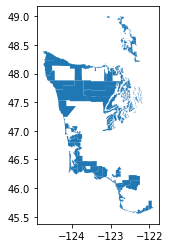

In [140]:
wa_vest_test = geom_validate1[0]
wa_geo_test = geom_validate1[1]
vest_false = wa_vest_test[wa_vest_test['GEOM_EQUALS']==False]
wa_geo_false = wa_geo_test[wa_geo_test['GEOM_EQUALS']==False]
vest_false.plot()

<AxesSubplot:>

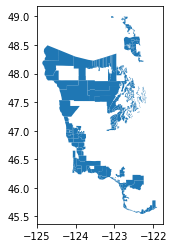

In [141]:
wa_geo_false.plot()

wa_geo = gp.read_file("raw-from-source/2018Precincts_OK_Consol/2018Precincts_OK_Consol.shp")
wa_vest = gp.read_file("raw-from-source/wa_2018/wa_2018.shp")

In [ ]:
wa_kings_names = pd.read_csv('raw-from-source/2018_Voting_Districts_for_King_County___votdst_area_2018.csv')
wa_kings_names["votdst"] = wa_kings_names["votdst"].astype('str').str.rjust(4, '0')
wa_kings_names = {name: num for name, num in zip(wa_kings_names["NAME"], wa_kings_names['votdst'])}
wa_king["Precinct"] = wa_king["Precinct"].apply(lambda x: wa_kings_names[x] if x in wa_kings_names else x)
#finding votes not associated with any precinct in king
display(wa_king[(wa_king["Precinct"] == "ELECTIONS OFFICE") & (wa_king["Race"] == 'US Senator') &
               ((wa_king["CounterType"] == "Maria Cantwell") | (wa_king["CounterType"] == "Susan Hutchison"))])

elections_office = wa_king[(wa_king["Precinct"] == "ELECTIONS OFFICE") & (wa_king["Race"] == 'US Senator') &
               ((wa_king["CounterType"] == "Maria Cantwell") | (wa_king["CounterType"] == "Susan Hutchison"))]

display(wa_king)

wa_king["FULLPRC"] = "KI" + wa_king["Precinct"].apply(lambda x:str(x).zfill(8))
wa_king = wa_king.pivot_table(index="FULLPRC", columns="CounterType", values="SumOfCount", aggfunc="first").reset_index()
display(wa_king)